In [1]:
import torch
import matplotlib.pyplot as plt 
import torch.nn.functional as F
%matplotlib inline


TEST


In [2]:
import math
math.exp(100)

2.6881171418161356e+43

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i:s for s,i in s_to_i.items()}
vocab_size = len(i_to_s)
vocab_size


27

In [6]:
device = 'cuda:0'
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X,device=device)
    Y = torch.tensor(Y,device=device)
    return X, Y
num = len(words)
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xval, Yval = build_dataset(words[n2:])

Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xval.shape, Yval.shape


(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

tensor([0.5374, 0.8247, 0.0923,  ..., 0.6972, 0.7919, 0.5866])


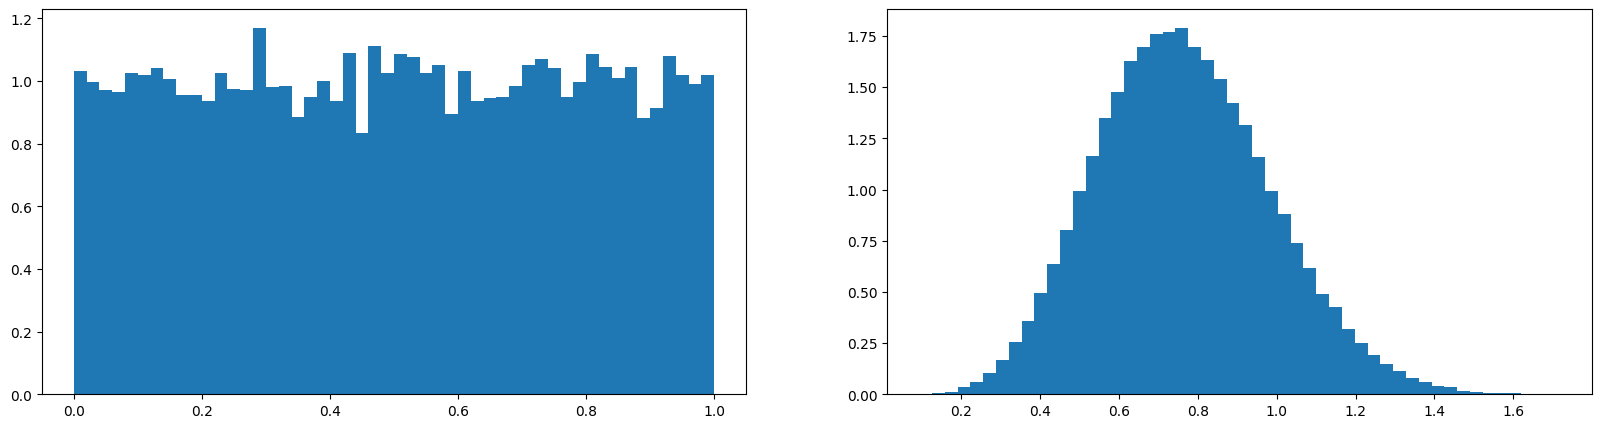

In [7]:
x= torch.rand(1000,10)
w= torch.rand(10,200) * .3
y= x @ w
print(x.view(-1))
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.cpu().view(-1),50,density=True)
plt.subplot(122)
plt.hist(y.cpu().view(-1),50,density=True);

In [8]:
n_embed = 10
n_hidden = 200
torch.manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),device=device)
W1 = torch.rand((n_embed * block_size, n_hidden),device=device) * 0.3
b1 = torch.rand(n_hidden,device=device)                         * 0.01
W2 = torch.rand(n_hidden, vocab_size,device=device)             * 0.01
b2 = torch.rand(vocab_size,device=device)                       * 0.01


# BatchNorm parameters
bngain = torch.ones((1, n_hidden),device=device)
bnbias = torch.zeros((1, n_hidden),device=device)
bnmean_running = torch.zeros((1, n_hidden),device=device)
bnstd_running = torch.ones((1, n_hidden),device=device)

parameters = [C, W1, W2, b2, bngain, bnbias]
# parameters = [C, W1, W2, b2, b1, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [9]:
max_steps = 200000
batch_size = 32
lossi = []
lossi_log = []
for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,),device=device)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi_log.append(loss.log10().item())
  lossi.append(loss.item())
  break

      0/ 200000: 3.2910


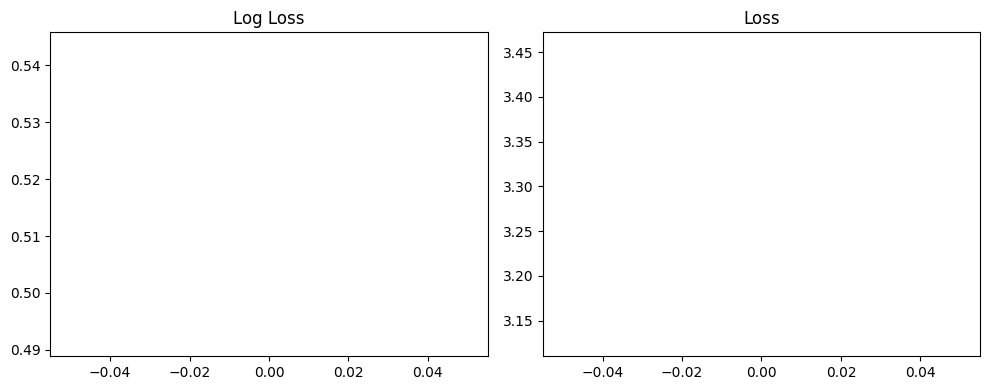

In [10]:
plt.figure(1, figsize=(10, 4))  # Adjust the figure size as needed
# Create the first subplot on the left
plt.subplot(121)  # 1 row, 2 columns, select the first subplot
plt.plot(lossi_log, label='Log Loss')
plt.title('Log Loss')
# Create the second subplot on the right
plt.subplot(122)  # 1 row, 2 columns, select the second subplot
plt.plot(lossi, label='Loss)')
plt.title('Loss')
# Adjust the spacing between subplots
plt.tight_layout()
# Display the figure with the two horizontally aligned subplots
plt.show()

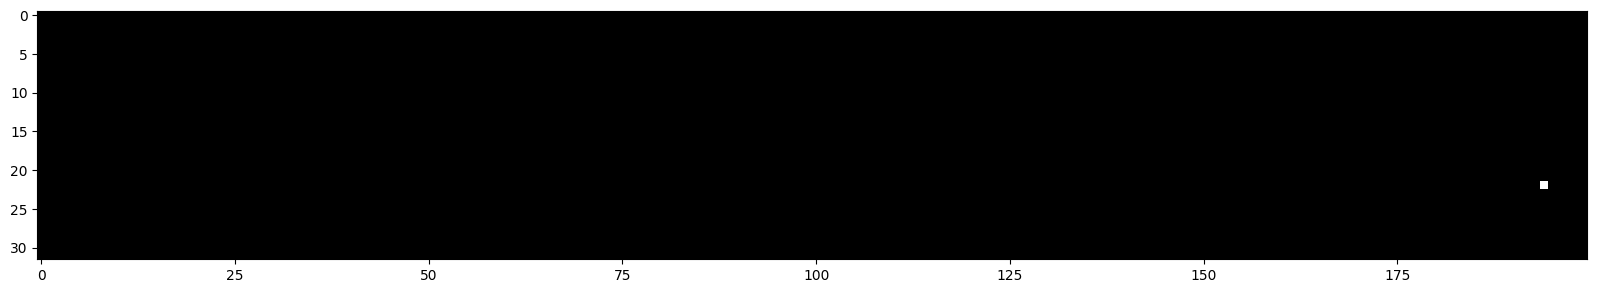

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.cpu().abs() > 0.99, cmap='gray', interpolation='nearest');

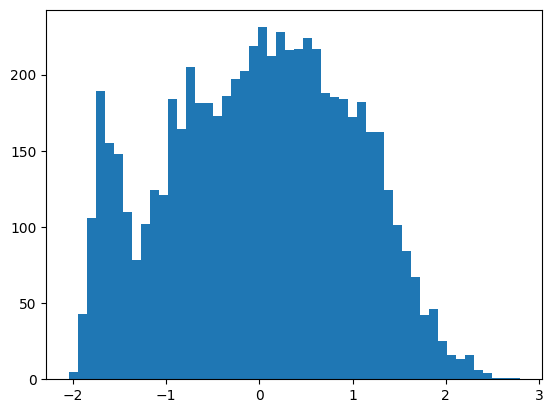

In [12]:
plt.hist(hpreact.view(-1).tolist(),50);

In [13]:
w

tensor([[0.2639, 0.1418, 0.2741,  ..., 0.0131, 0.1927, 0.1026],
        [0.0557, 0.1093, 0.0202,  ..., 0.2894, 0.0134, 0.1274],
        [0.1595, 0.1452, 0.2901,  ..., 0.2167, 0.2330, 0.0974],
        ...,
        [0.2082, 0.2220, 0.0852,  ..., 0.0643, 0.0531, 0.1624],
        [0.1972, 0.0405, 0.1666,  ..., 0.2868, 0.2159, 0.0718],
        [0.2340, 0.0393, 0.1441,  ..., 0.0317, 0.2485, 0.0762]])

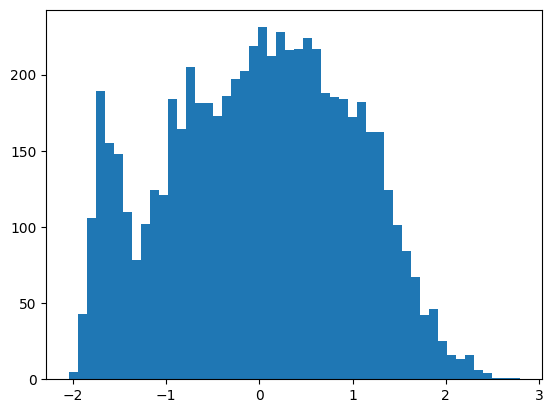

In [14]:
plt.hist(hpreact.view(-1).tolist(),50);

In [15]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xval, Yval),
  }[split]

  # x = x.to(device)
  # y = x.to(device)

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.367155075073242
val 3.366396188735962


In [17]:
device = 'cpu'

#### LOG
 - train 6.748948574066162 and val 6.758888244628906
 - train 3.210315227508545 and val 3.2052133083343506

In [18]:
from Package_Class import Settings
from Package_Plot import plot_graphs,generate_data
from Package_Parameter import generate_parameter


In [19]:
%autoreload

UsageError: Line magic function `%autoreload` not found.


      0/ 200000: 3.2870
 Statististics for Graph 1
layer 0 (    Linear): mean -0.10, std +1.707251, saturated: 57.16%
layer 3 (    Linear): mean +0.00, std +1.097428, saturated: 37.75%
layer 6 (    Linear): mean -0.01, std +1.183158, saturated: 42.72%
layer 9 (    Linear): mean -0.00, std +1.165383, saturated: 43.34%
layer 12 (    Linear): mean -0.00, std +1.210009, saturated: 44.00%
layer 15 (    Linear): mean -0.01, std +1.443935, saturated: 47.92%
 
 Statististics for Graph 2
layer 0 (    Linear): mean +0.000000, std +0.001726
layer 3 (    Linear): mean +0.000000, std +0.002122
layer 6 (    Linear): mean -0.000000, std +0.001864
layer 9 (    Linear): mean -0.000000, std +0.001685
layer 12 (    Linear): mean -0.000000, std +0.001545
layer 15 (    Linear): mean -0.000000, std +0.003016
 
 Statististics for Graph 3
weight   (27, 10) | mean +0.000000 | std +0.010199 | grad:data ratio  +0.010188
weight  (30, 100) | mean +0.000092 | std +0.008238 | grad:data ratio  +0.026358
weight (100, 

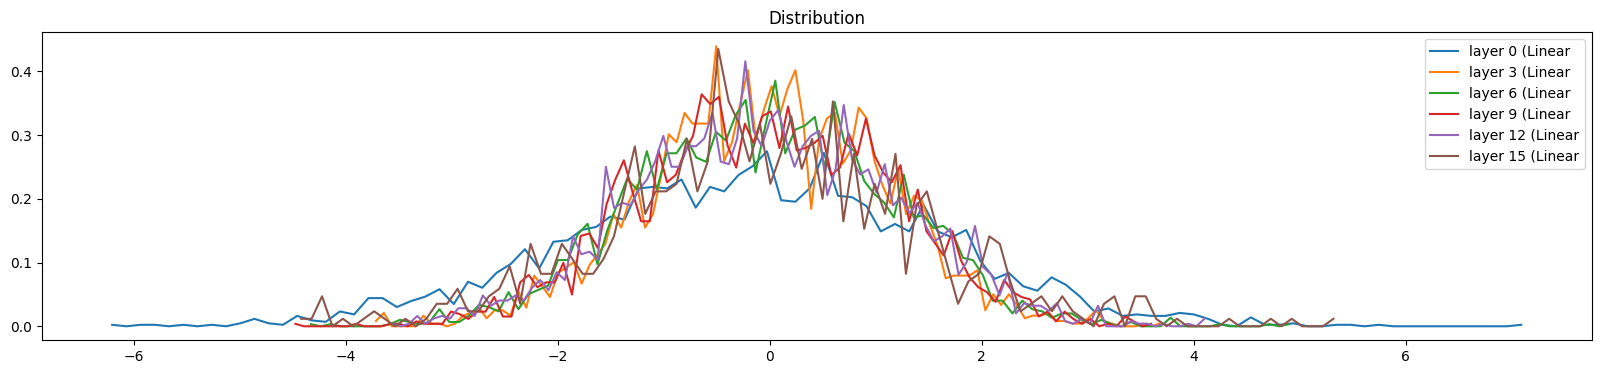

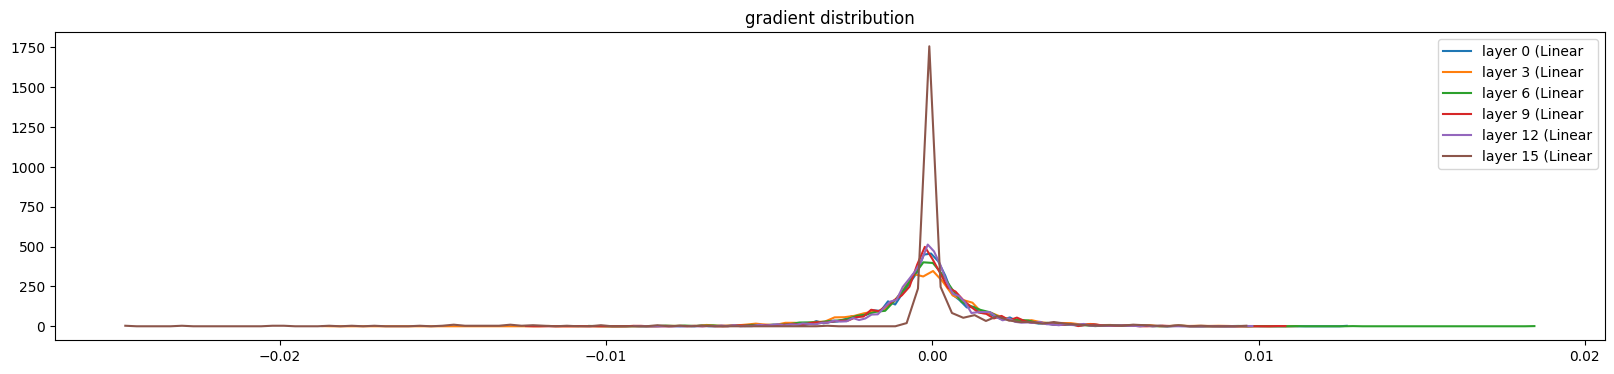

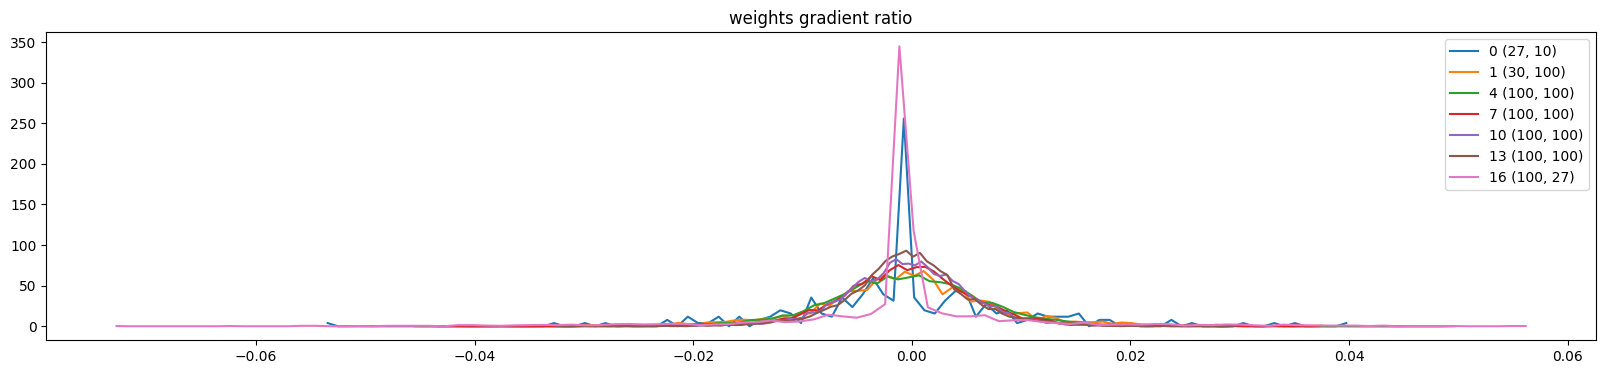

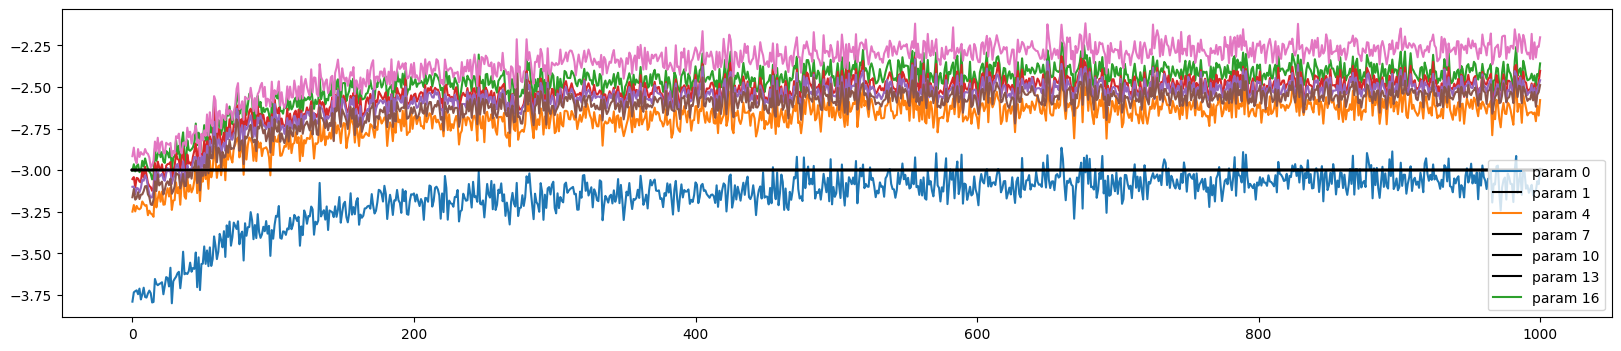

In [20]:
settings_dict = dict(
    is_batch_norm_enable=True,
    is_there_activation=True,
    is_bias_zero=True,
    lr=0.1,
    gain=5/3
)
g = torch.Generator().manual_seed(2147483647) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 3.3702
 Statististics for Graph 1
layer 1 (      Tanh): mean -0.04, std +0.645343, saturated: 5.91%
layer 3 (      Tanh): mean -0.01, std +0.556215, saturated: 0.56%
layer 5 (      Tanh): mean +0.01, std +0.544100, saturated: 0.75%
layer 7 (      Tanh): mean -0.04, std +0.544095, saturated: 0.31%
layer 9 (      Tanh): mean +0.02, std +0.560473, saturated: 1.03%
 
 Statististics for Graph 2
layer 1 (      Tanh): mean +0.000063, std +0.002902
layer 3 (      Tanh): mean +0.000051, std +0.002652
layer 5 (      Tanh): mean +0.000029, std +0.002646
layer 7 (      Tanh): mean -0.000019, std +0.002638
layer 9 (      Tanh): mean -0.000023, std +0.003058
 
 Statististics for Graph 3
weight   (27, 10) | mean +0.000234 | std +0.009532 | grad:data ratio  +0.009451
weight  (30, 100) | mean +0.000205 | std +0.010500 | grad:data ratio  +0.054315
weight (100, 100) | mean +0.000045 | std +0.007017 | grad:data ratio  +0.067228
weight (100, 100) | mean +0.000020 | std +0.005804 | grad:dat

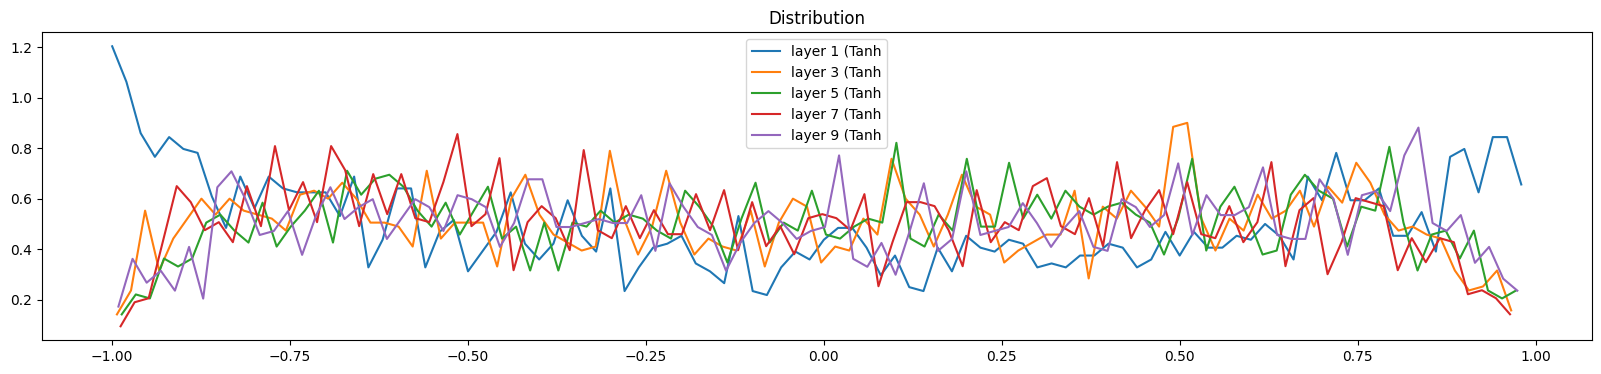

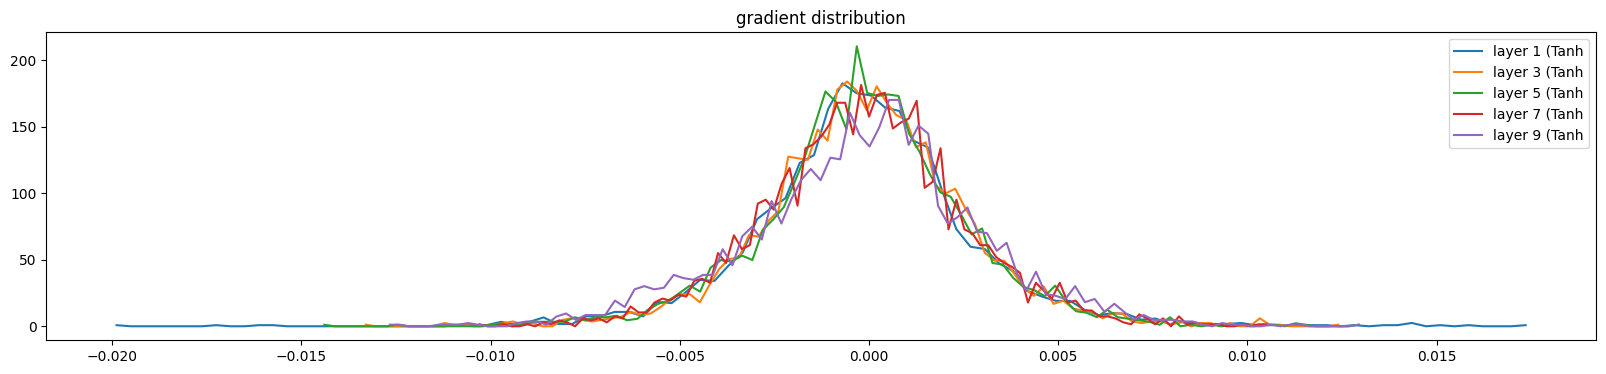

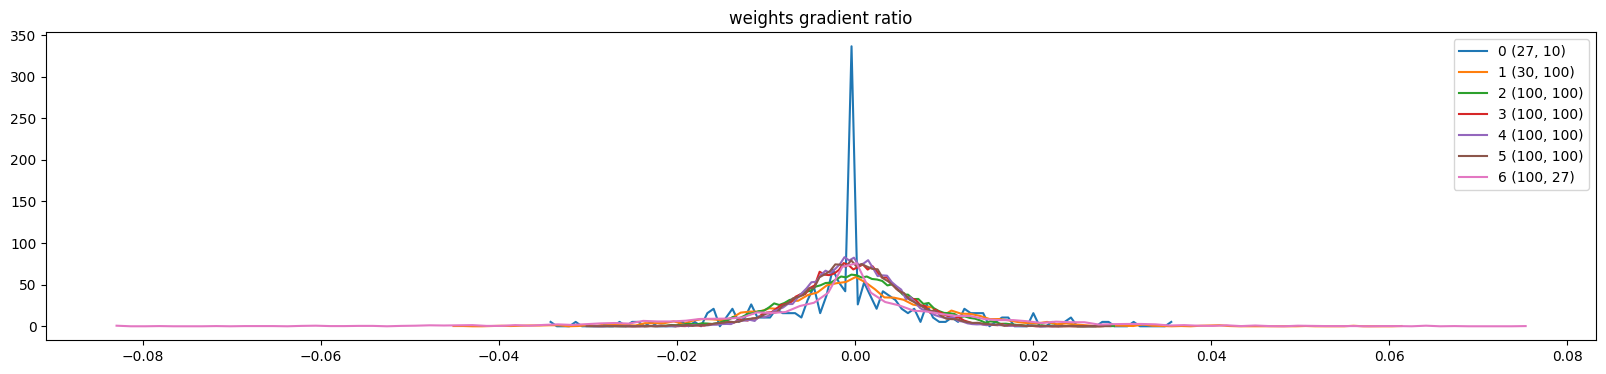

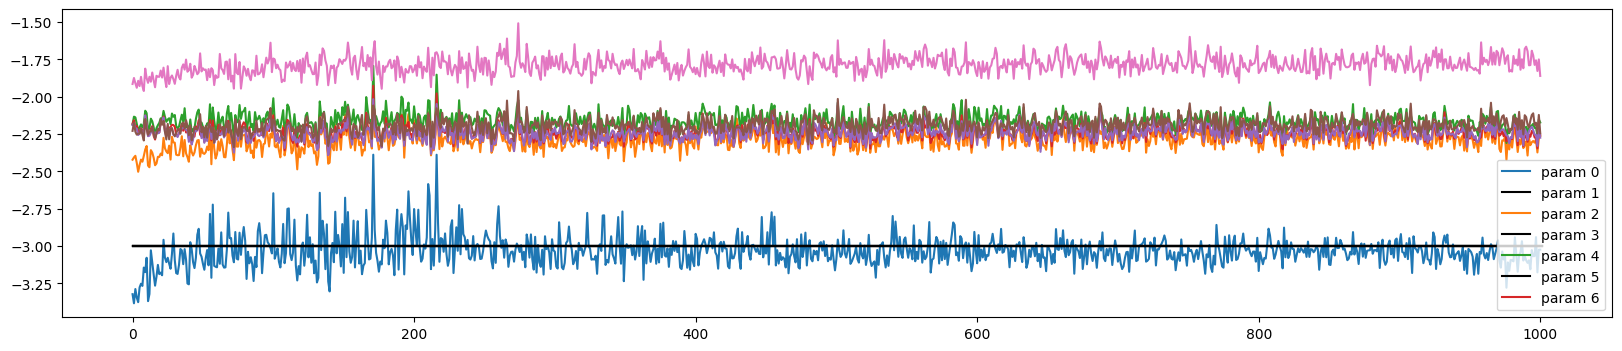

In [21]:
settings_dict = dict(
    is_batch_norm_enable=False,
    is_there_activation=True,
    is_bias_zero=True,
    lr=0.1,
    gain=1
)
g = torch.Generator().manual_seed(2147483647) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

Tanh is squashing, gain is needed (5/3)

      0/ 200000: 3.4594
 Statististics for Graph 1
layer 1 (      Tanh): mean -0.06, std +0.918739, saturated: 68.09%
layer 3 (      Tanh): mean -0.01, std +0.927115, saturated: 68.31%
layer 5 (      Tanh): mean +0.05, std +0.929918, saturated: 70.59%
layer 7 (      Tanh): mean -0.02, std +0.928175, saturated: 69.38%
layer 9 (      Tanh): mean +0.02, std +0.930107, saturated: 69.91%
 
 Statististics for Graph 2
layer 1 (      Tanh): mean +0.000116, std +0.013202
layer 3 (      Tanh): mean -0.000193, std +0.008453
layer 5 (      Tanh): mean -0.000139, std +0.005574
layer 7 (      Tanh): mean -0.000035, std +0.003593
layer 9 (      Tanh): mean +0.000040, std +0.002521
 
 Statististics for Graph 3
weight   (27, 10) | mean -0.003266 | std +0.073328 | grad:data ratio  +0.070753
weight  (30, 100) | mean +0.000489 | std +0.023795 | grad:data ratio  +0.025322
weight (100, 100) | mean +0.000240 | std +0.013619 | grad:data ratio  +0.027169
weight (100, 100) | mean -0.000079 | std +0.008855 | gra

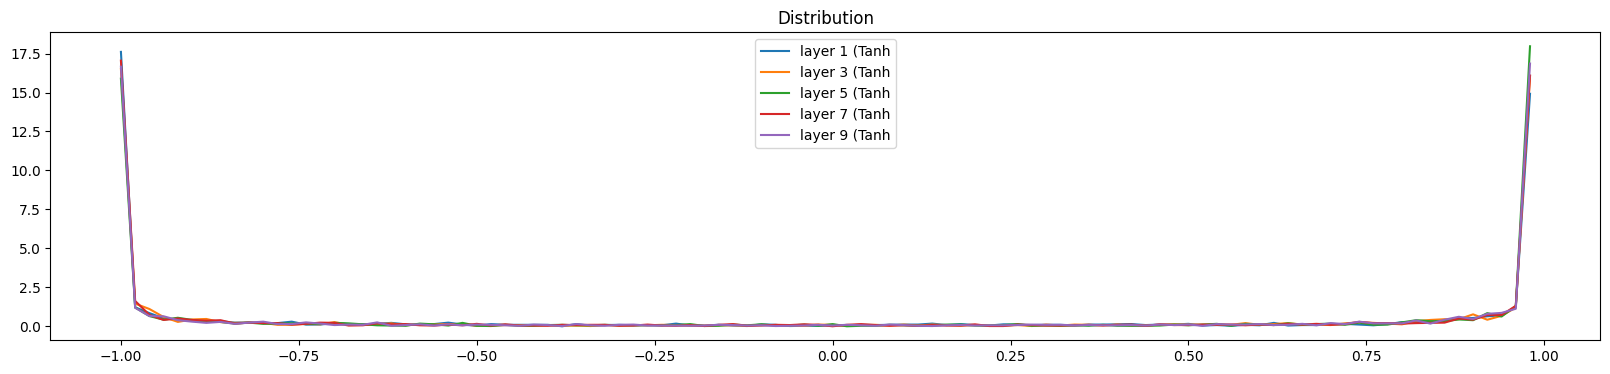

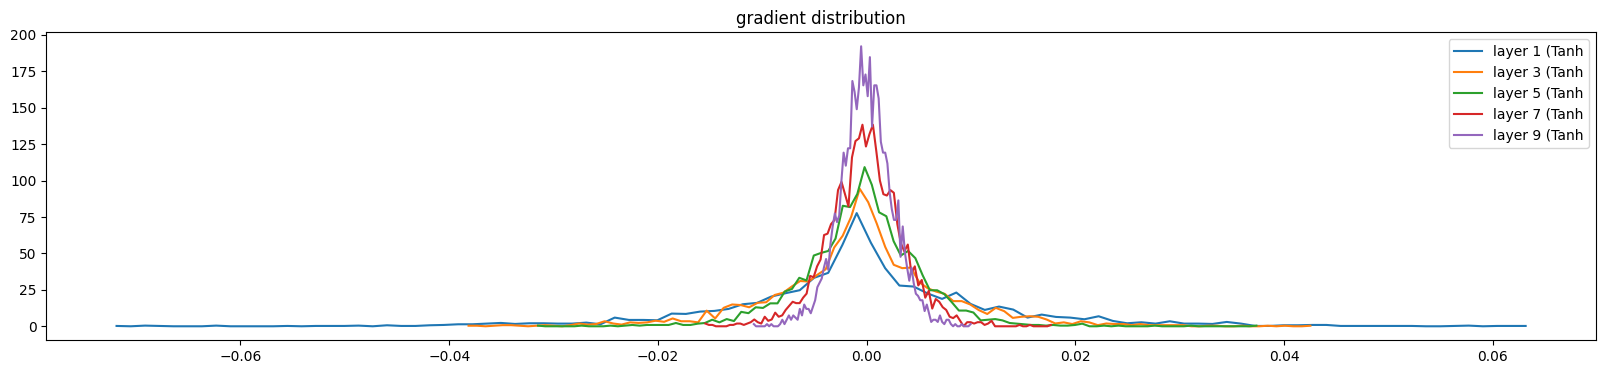

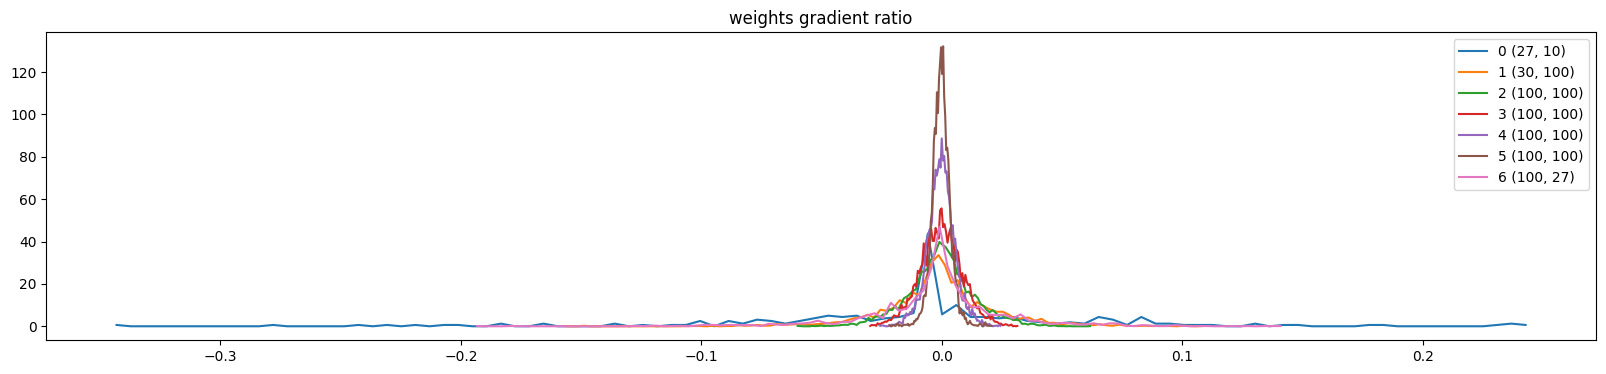

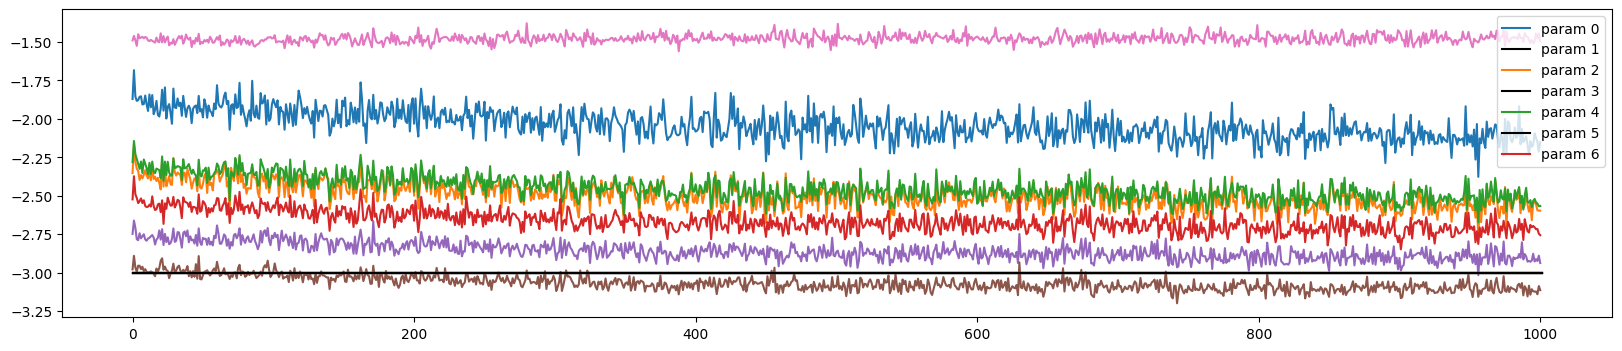

In [22]:
settings_dict = dict(
    is_batch_norm_enable=False,
    is_there_activation=True,
    is_bias_zero=True,
    lr=0.1,
    gain=5
)
g = torch.Generator().manual_seed(2147483647) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

Higher gain creates too much saturation ( Some neurons will not learn )

      0/ 200000: 3.2959
 Statististics for Graph 1
layer 1 (      Tanh): mean -0.04, std +0.354104, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std +0.269967, saturated: 0.00%
layer 5 (      Tanh): mean -0.01, std +0.277561, saturated: 0.00%
layer 7 (      Tanh): mean -0.02, std +0.291196, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std +0.353172, saturated: 0.00%
 
 Statististics for Graph 2
layer 1 (      Tanh): mean +0.000050, std +0.002043
layer 3 (      Tanh): mean -0.000002, std +0.001803
layer 5 (      Tanh): mean +0.000030, std +0.001710
layer 7 (      Tanh): mean +0.000011, std +0.001819
layer 9 (      Tanh): mean -0.000055, std +0.003039
 
 Statististics for Graph 3
weight   (27, 10) | mean +0.000616 | std +0.011968 | grad:data ratio  +0.011904
weight  (30, 100) | mean +0.000345 | std +0.008887 | grad:data ratio  +0.132179
weight (100, 100) | mean +0.000013 | std +0.003150 | grad:data ratio  +0.091872
weight (100, 100) | mean +0.000008 | std +0.002063 | grad:dat

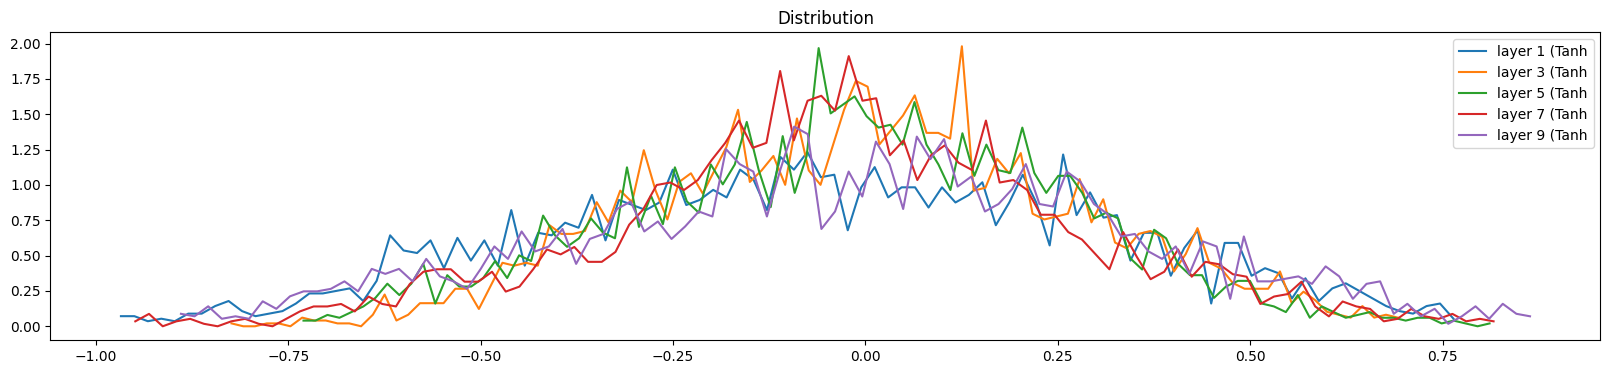

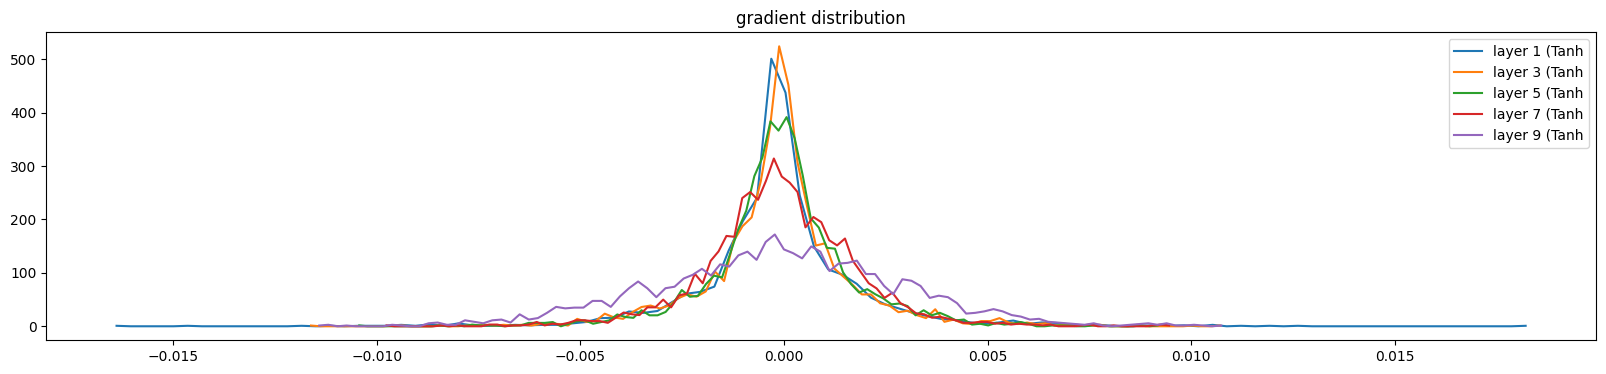

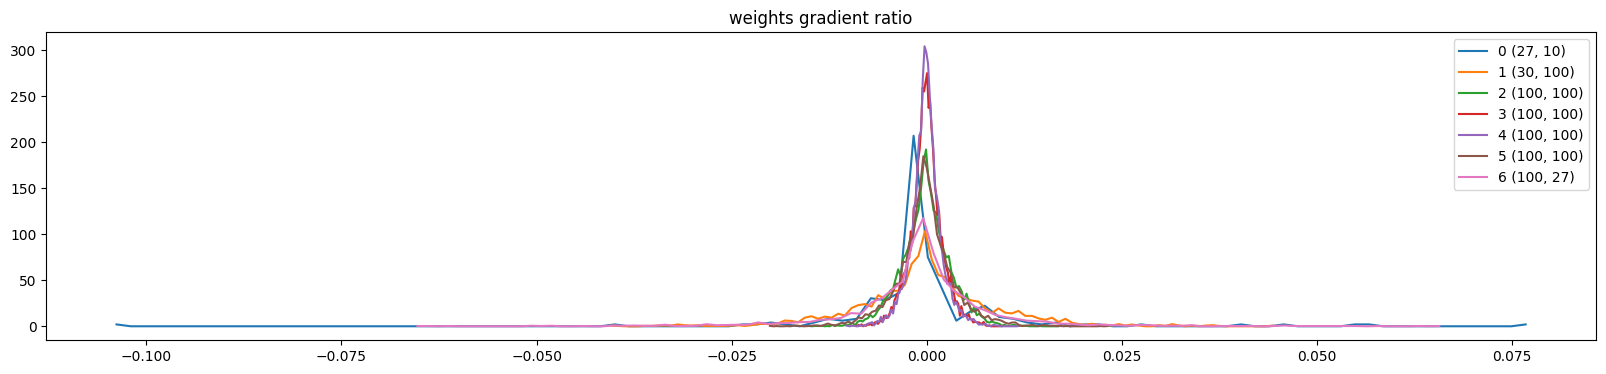

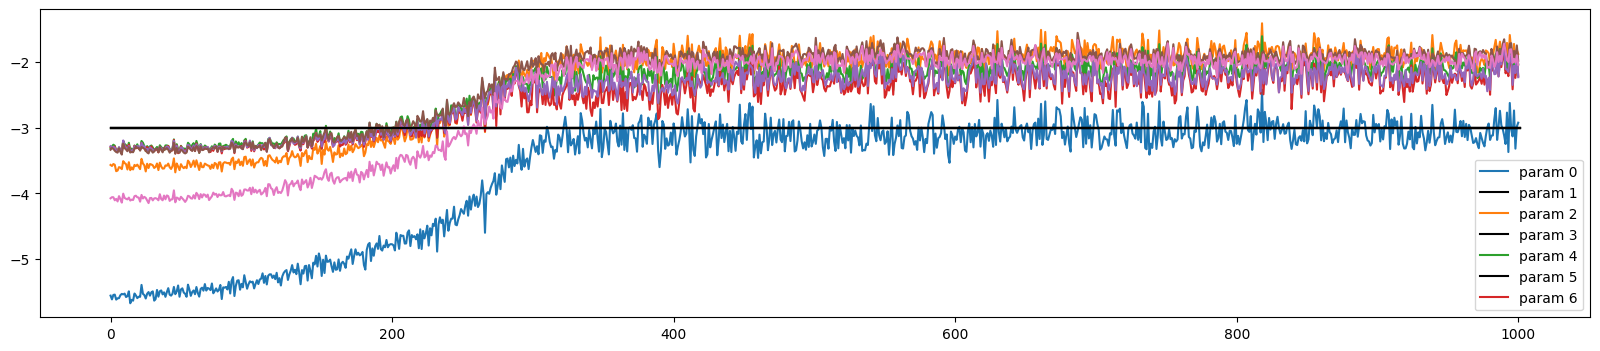

In [23]:
settings_dict = dict(
    is_batch_norm_enable=False,
    is_there_activation=True,
    is_bias_zero=True,
    lr=0.1,
    gain=0.3
)
g = torch.Generator().manual_seed(2147483647) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 8.4262
 Statististics for Graph 1
layer 0 (    Linear): mean +0.03, std +0.838402, saturated: 23.44%
layer 1 (    Linear): mean -0.06, std +0.775213, saturated: 20.91%
layer 2 (    Linear): mean +0.01, std +0.765696, saturated: 19.69%
layer 3 (    Linear): mean +0.04, std +0.722206, saturated: 16.59%
layer 4 (    Linear): mean +0.02, std +0.661026, saturated: 13.53%
 
 Statististics for Graph 2
layer 0 (    Linear): mean +0.000041, std +0.002915
layer 1 (    Linear): mean -0.000033, std +0.001994
layer 2 (    Linear): mean +0.000043, std +0.001910
layer 3 (    Linear): mean +0.000102, std +0.001915
layer 4 (    Linear): mean +0.000042, std +0.001930
 
 Statististics for Graph 3
weight   (27, 10) | mean -0.001795 | std +0.026858 | grad:data ratio  +0.031471
weight  (30, 100) | mean -0.000125 | std +0.013259 | grad:data ratio  +0.061483
weight (100, 100) | mean +0.000090 | std +0.009267 | grad:data ratio  +0.073100
weight (100, 100) | mean -0.000060 | std +0.007534 | gra

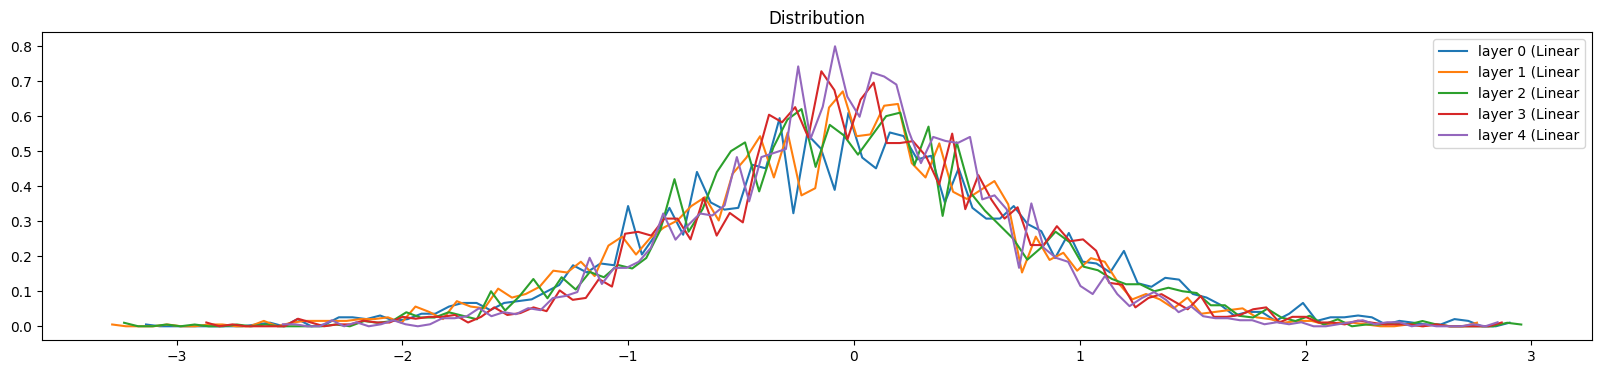

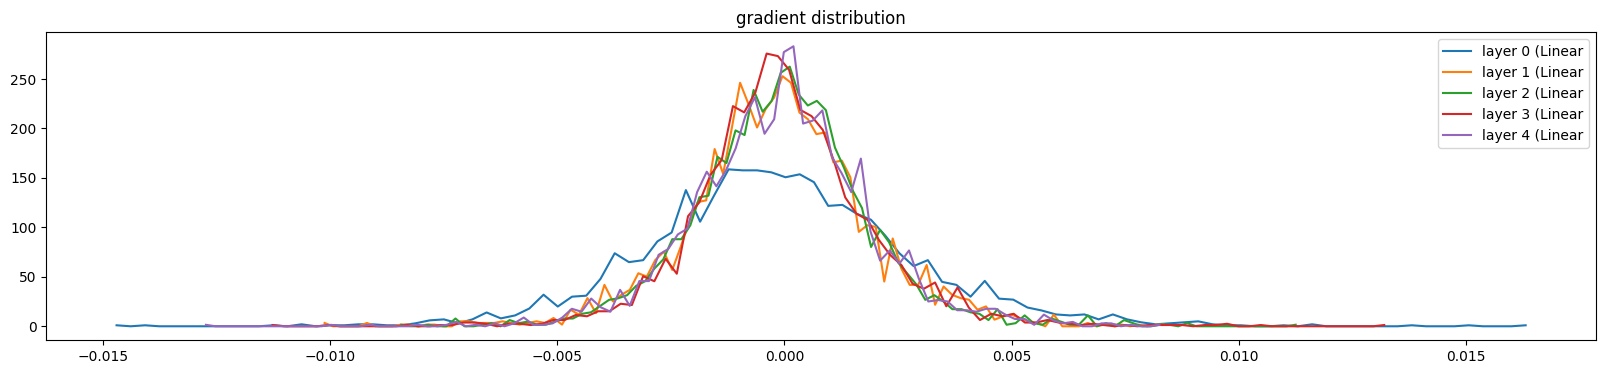

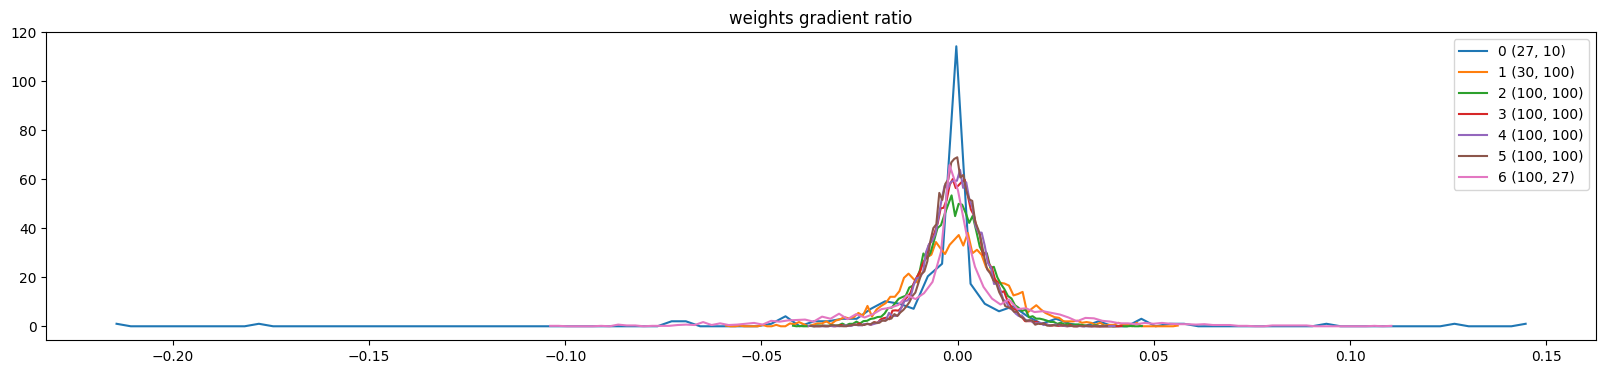

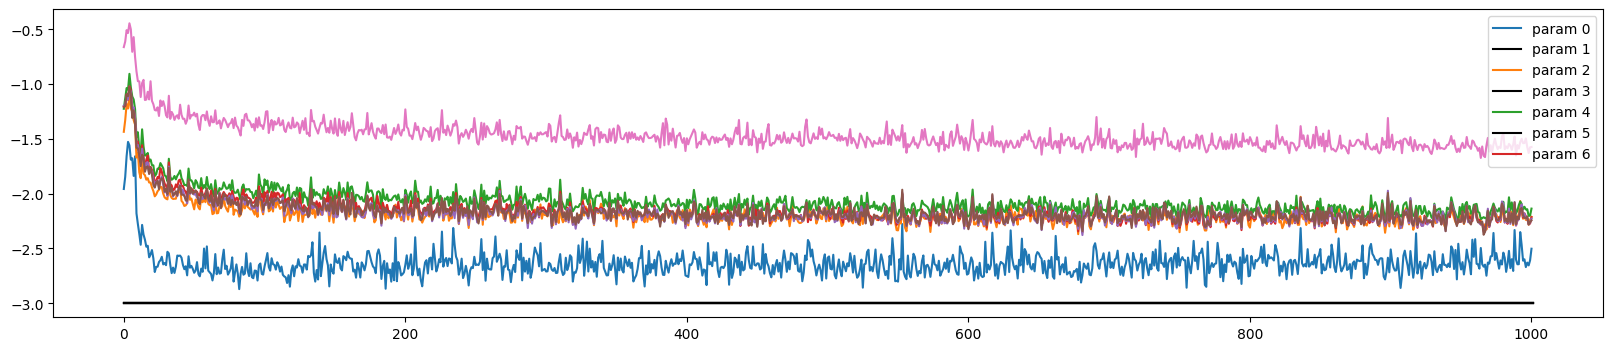

In [24]:
settings_dict = dict(
    is_batch_norm_enable=False,
    is_there_activation=False,
    is_bias_zero=False,
    lr=0.1,
    gain=1.35
)
g = torch.Generator().manual_seed(214748433) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 3.5057
 Statististics for Graph 1
layer 1 (      Tanh): mean +0.02, std +0.753311, saturated: 19.00%
layer 3 (      Tanh): mean -0.04, std +0.696128, saturated: 9.91%
layer 5 (      Tanh): mean -0.03, std +0.682205, saturated: 7.78%
layer 7 (      Tanh): mean +0.02, std +0.673705, saturated: 6.44%
layer 9 (      Tanh): mean +0.03, std +0.670025, saturated: 6.81%
 
 Statististics for Graph 2
layer 1 (      Tanh): mean +0.000168, std +0.003756
layer 3 (      Tanh): mean +0.000044, std +0.003552
layer 5 (      Tanh): mean +0.000105, std +0.003422
layer 7 (      Tanh): mean +0.000016, std +0.003270
layer 9 (      Tanh): mean +0.000049, std +0.003083
 
 Statististics for Graph 3
weight   (27, 10) | mean -0.000828 | std +0.011912 | grad:data ratio  +0.012564
weight  (30, 100) | mean -0.000481 | std +0.010926 | grad:data ratio  +0.036560
weight (100, 100) | mean +0.000053 | std +0.009331 | grad:data ratio  +0.055808
weight (100, 100) | mean -0.000050 | std +0.008604 | grad:da

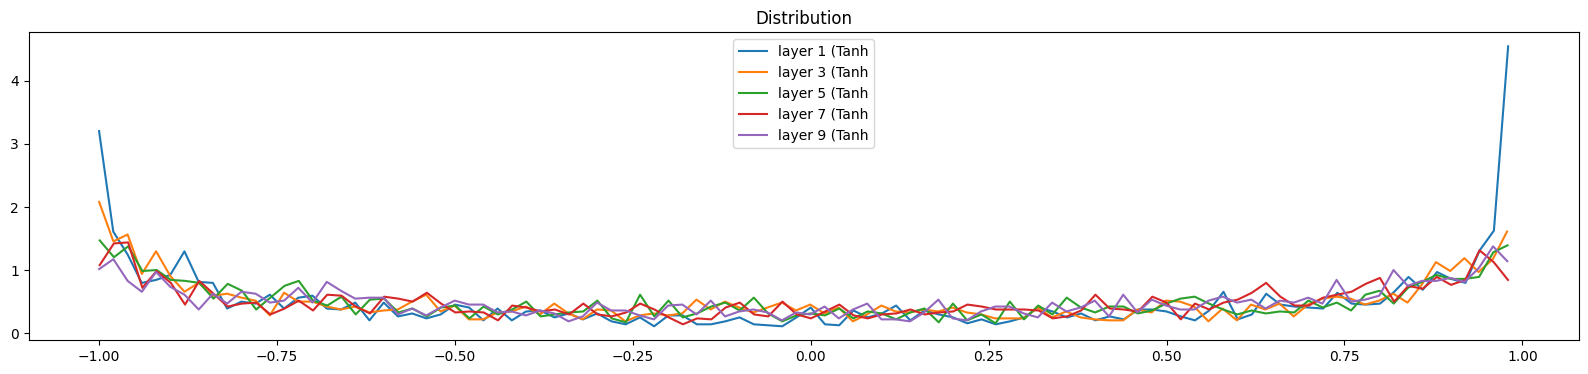

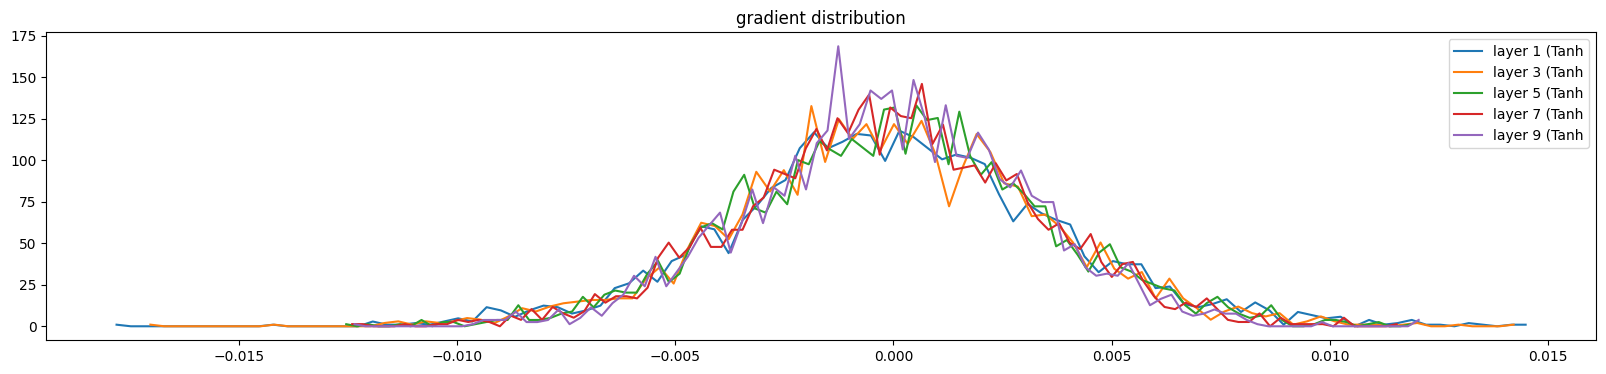

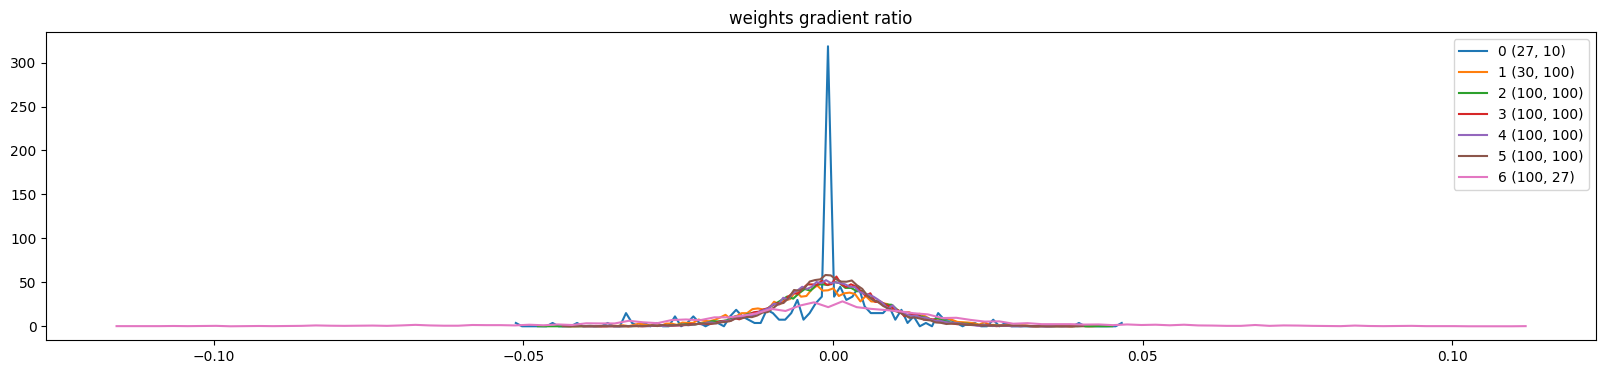

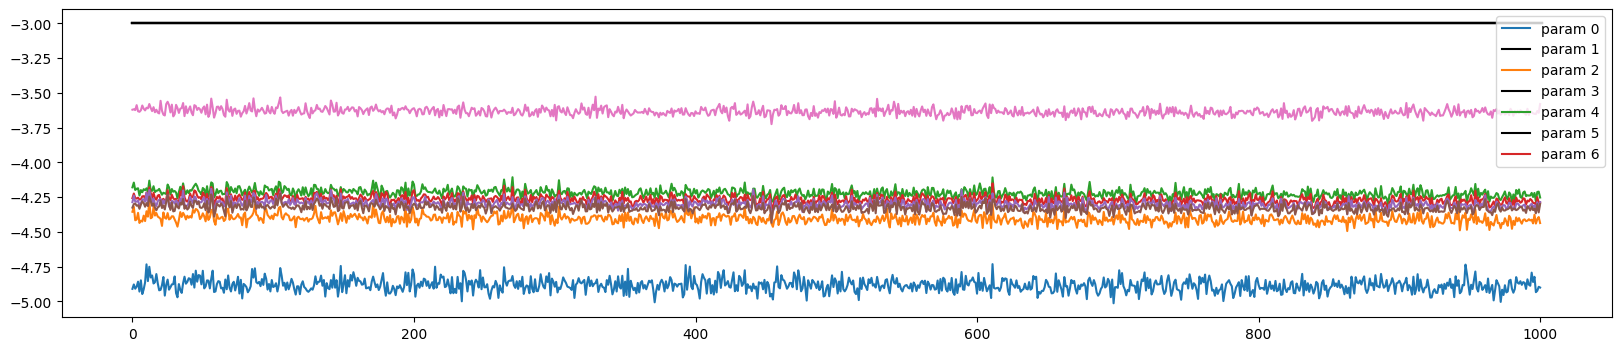

In [25]:
settings_dict = dict(
    is_batch_norm_enable=False,
    is_there_activation=True,
    is_bias_zero=False,
    lr=0.001,
    gain=5/3
)
g = torch.Generator().manual_seed(214748433) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 3.2840
 Statististics for Graph 1
layer 0 (    Linear): mean +0.07, std +1.806337, saturated: 58.84%
layer 3 (    Linear): mean +0.00, std +1.620552, saturated: 58.44%
layer 6 (    Linear): mean -0.01, std +1.774147, saturated: 65.41%
layer 9 (    Linear): mean +0.01, std +1.791476, saturated: 66.06%
layer 12 (    Linear): mean +0.01, std +1.953726, saturated: 71.50%
layer 15 (    Linear): mean +0.04, std +4.239329, saturated: 76.62%
 
 Statististics for Graph 2
layer 0 (    Linear): mean -0.000000, std +0.000696
layer 3 (    Linear): mean -0.000000, std +0.000556
layer 6 (    Linear): mean +0.000000, std +0.000502
layer 9 (    Linear): mean +0.000000, std +0.000507
layer 12 (    Linear): mean -0.000000, std +0.000500
layer 15 (    Linear): mean +0.000000, std +0.001267
 
 Statististics for Graph 3
weight   (27, 10) | mean +0.000000 | std +0.006197 | grad:data ratio  +0.006365
weight  (30, 100) | mean +0.000057 | std +0.003196 | grad:data ratio  +0.009903
weight (100, 

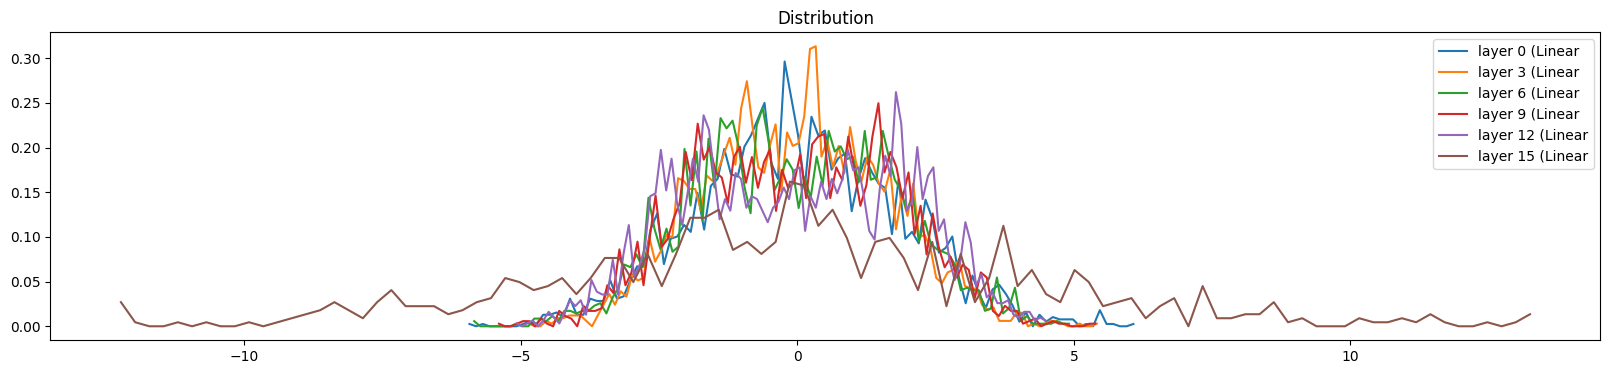

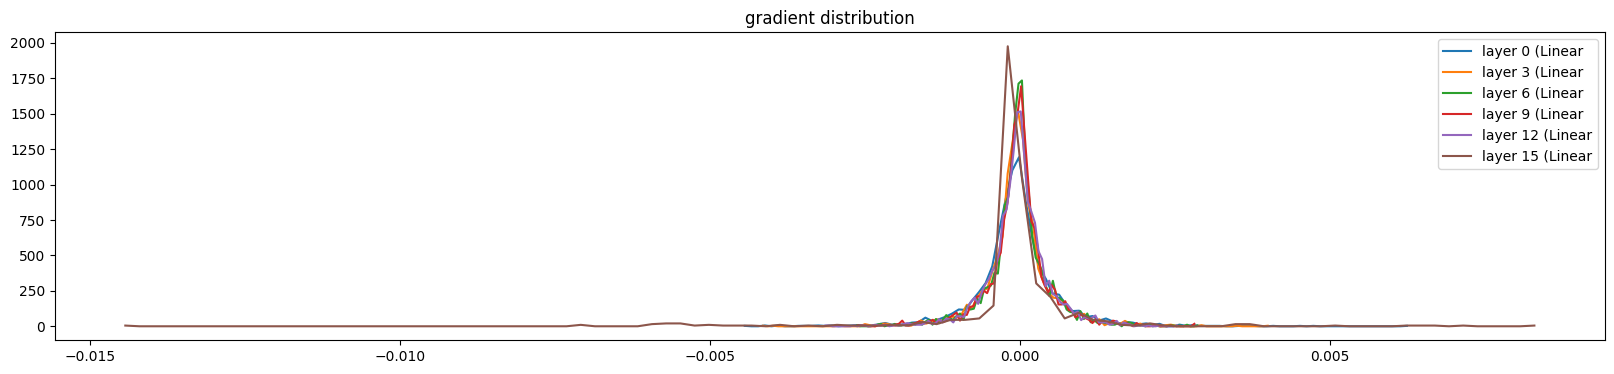

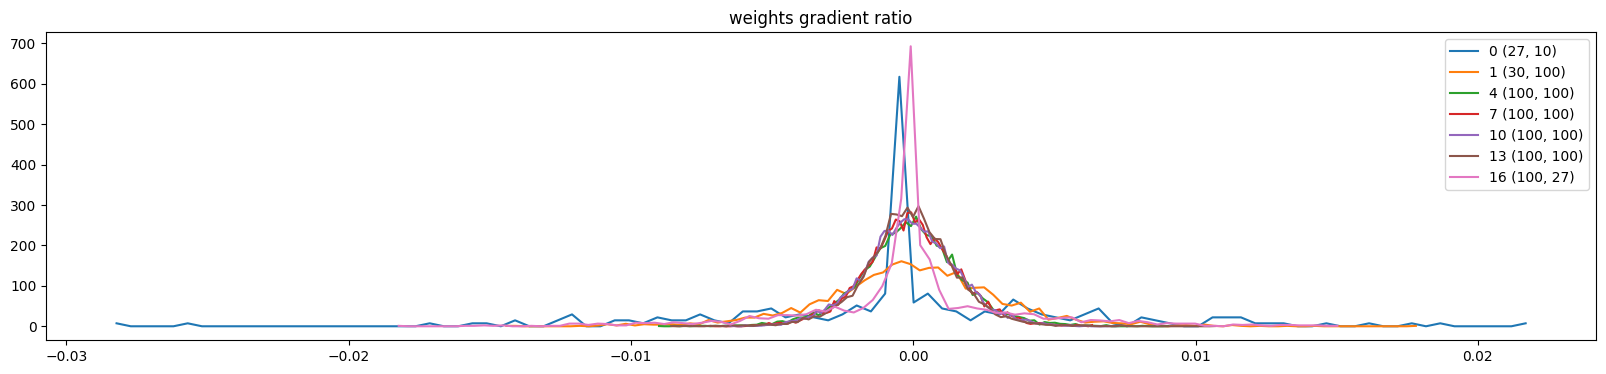

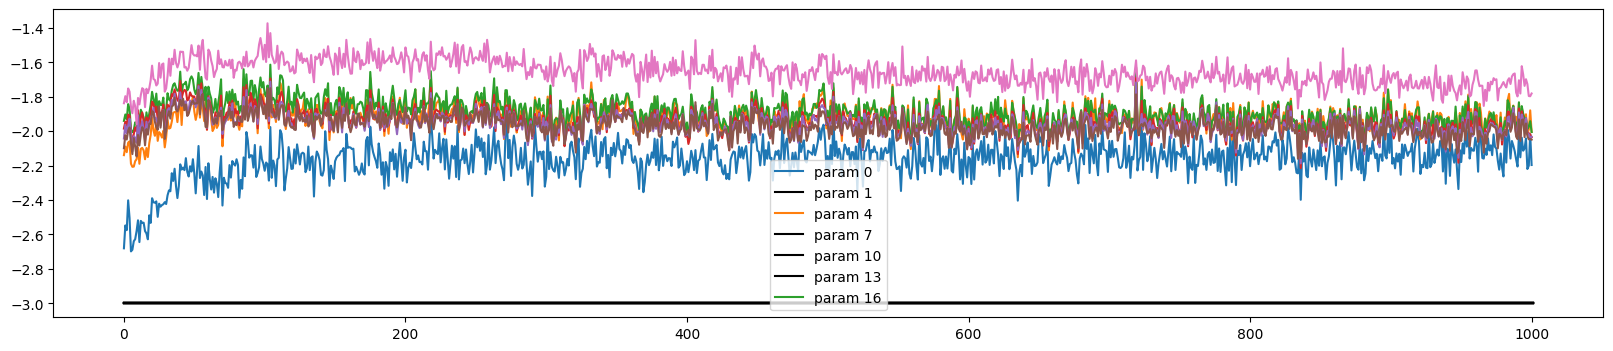

In [27]:
settings_dict = dict(
    is_batch_norm_enable=True,
    is_there_activation=True,
    is_bias_zero=False,
    lr=1,
    gain=5/3
)
g = torch.Generator().manual_seed(214748433) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 3.2840
 Statististics for Graph 1
layer 0 (    Linear): mean +0.09, std +1.678469, saturated: 57.38%
layer 3 (    Linear): mean +0.01, std +1.121150, saturated: 38.81%
layer 6 (    Linear): mean -0.01, std +1.171752, saturated: 44.00%
layer 9 (    Linear): mean -0.00, std +1.162425, saturated: 43.53%
layer 12 (    Linear): mean +0.01, std +1.207213, saturated: 46.31%
layer 15 (    Linear): mean -0.01, std +1.580613, saturated: 52.89%
 
 Statististics for Graph 2
layer 0 (    Linear): mean -0.000000, std +0.001318
layer 3 (    Linear): mean +0.000000, std +0.001509
layer 6 (    Linear): mean +0.000000, std +0.001435
layer 9 (    Linear): mean +0.000000, std +0.001323
layer 12 (    Linear): mean +0.000000, std +0.001300
layer 15 (    Linear): mean -0.000000, std +0.002607
 
 Statististics for Graph 3
weight   (27, 10) | mean -0.000000 | std +0.006844 | grad:data ratio  +0.007215
weight  (30, 100) | mean -0.000204 | std +0.005906 | grad:data ratio  +0.019713
weight (100, 

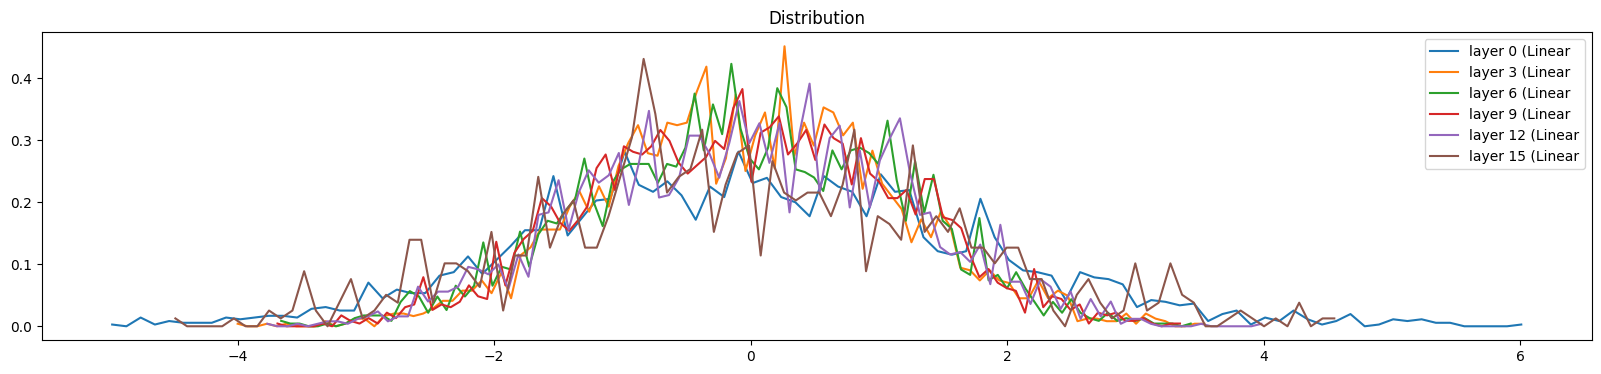

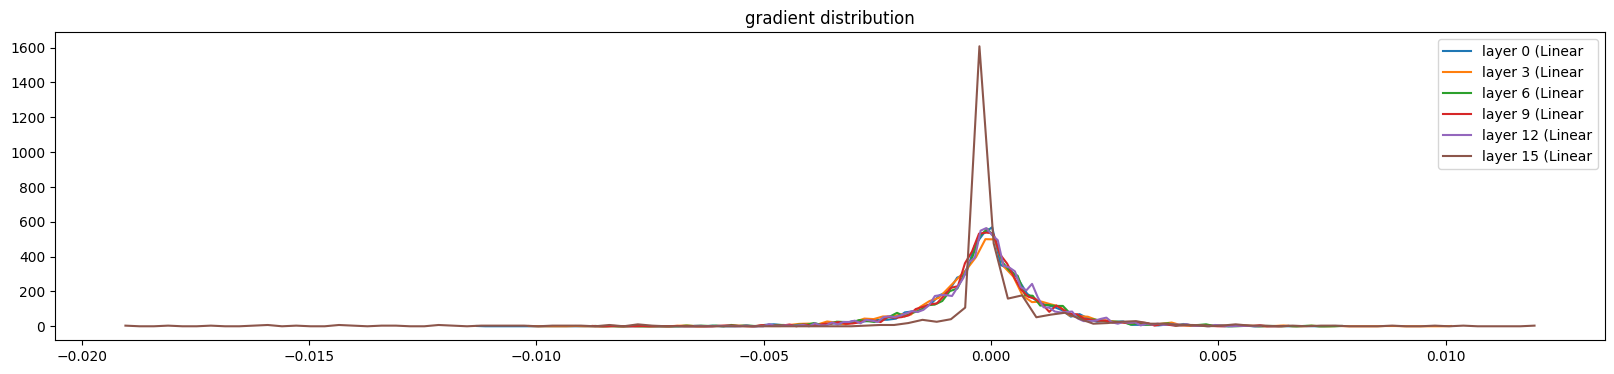

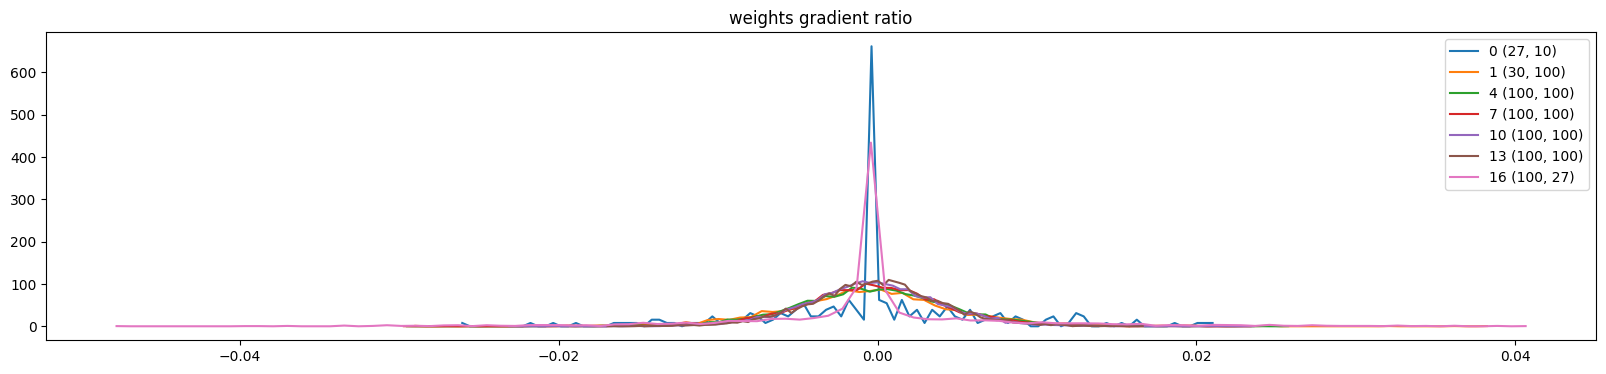

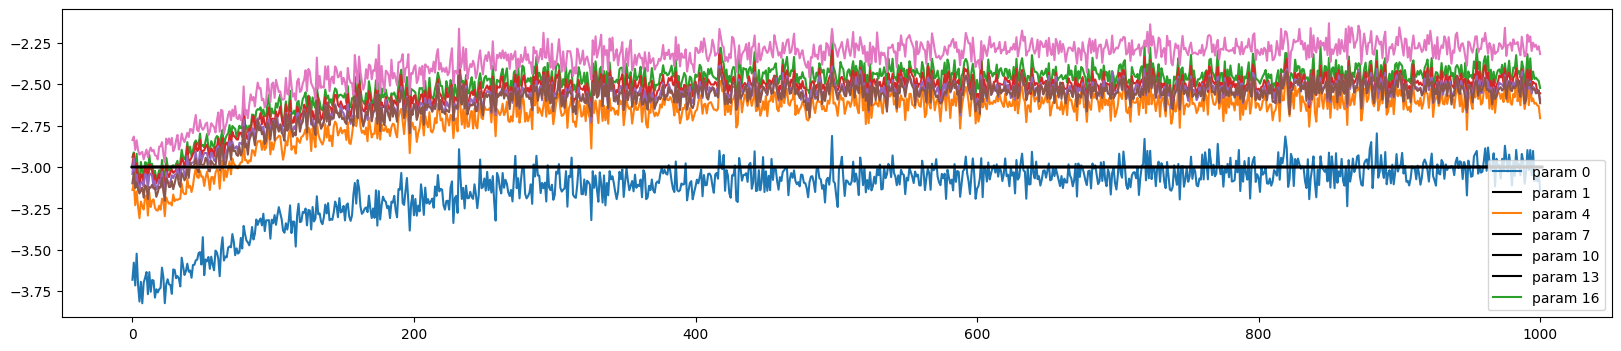

In [31]:
settings_dict = dict(
    is_batch_norm_enable=True,
    is_there_activation=True,
    is_bias_zero=False,
    lr=0.1,
    gain=5/3
)
g = torch.Generator().manual_seed(214748433) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)

      0/ 200000: 3.2840
 Statististics for Graph 1
layer 0 (    Linear): mean +0.02, std +0.332580, saturated: 0.09%
layer 3 (    Linear): mean -0.00, std +0.378169, saturated: 0.62%
layer 6 (    Linear): mean -0.00, std +0.404960, saturated: 0.22%
layer 9 (    Linear): mean -0.00, std +0.417274, saturated: 0.31%
layer 12 (    Linear): mean +0.00, std +0.454530, saturated: 0.25%
layer 15 (    Linear): mean -0.00, std +1.140898, saturated: 34.95%
 
 Statististics for Graph 2
layer 0 (    Linear): mean -0.000000, std +0.002307
layer 3 (    Linear): mean -0.000000, std +0.001458
layer 6 (    Linear): mean +0.000000, std +0.001325
layer 9 (    Linear): mean +0.000000, std +0.001330
layer 12 (    Linear): mean -0.000000, std +0.001357
layer 15 (    Linear): mean -0.000000, std +0.003613
 
 Statististics for Graph 3
weight   (27, 10) | mean +0.000000 | std +0.006176 | grad:data ratio  +0.006512
weight  (30, 100) | mean -0.000362 | std +0.010580 | grad:data ratio  +0.177242
weight (100, 100) 

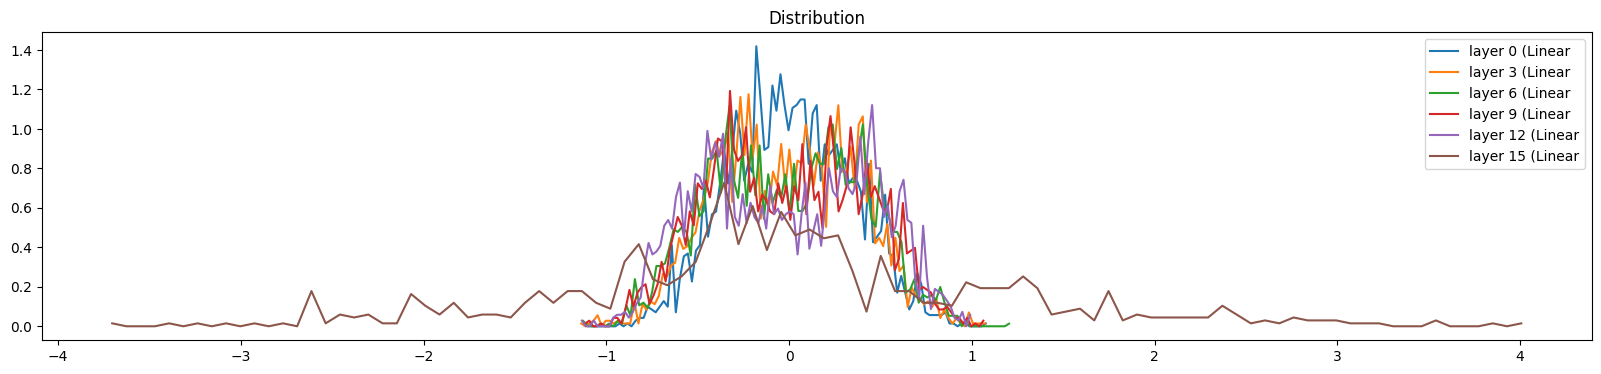

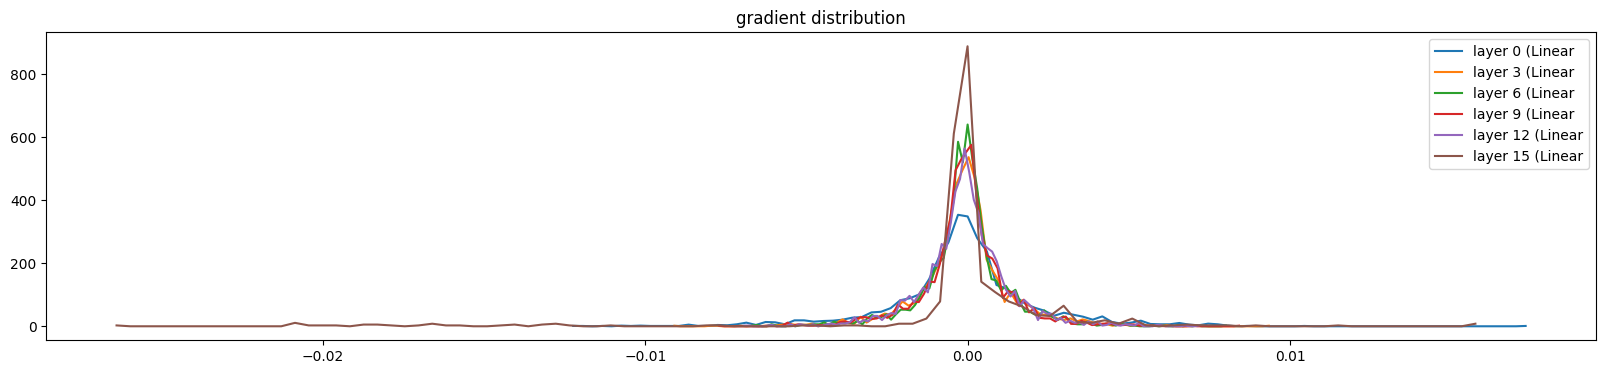

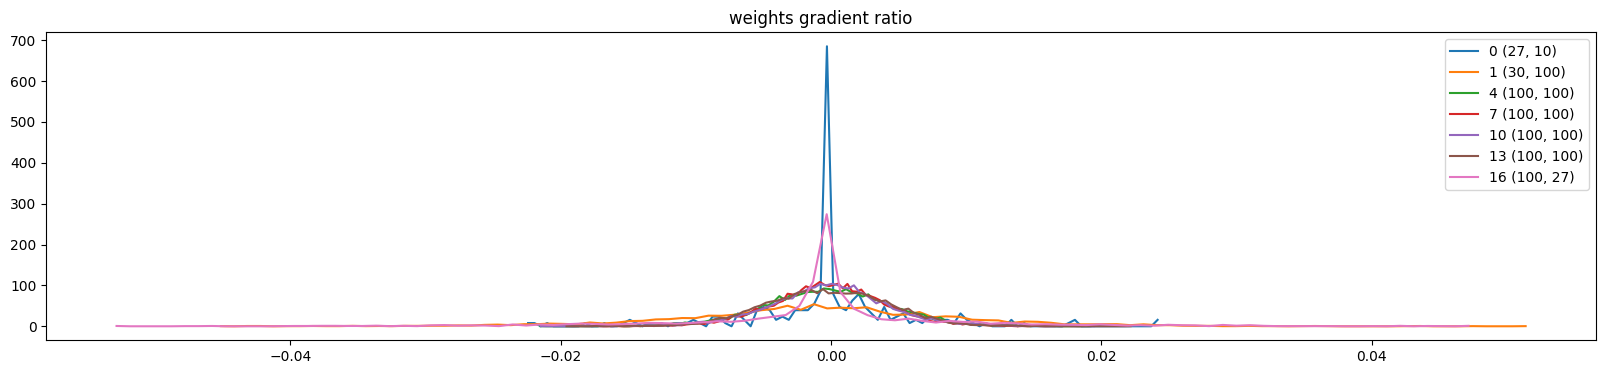

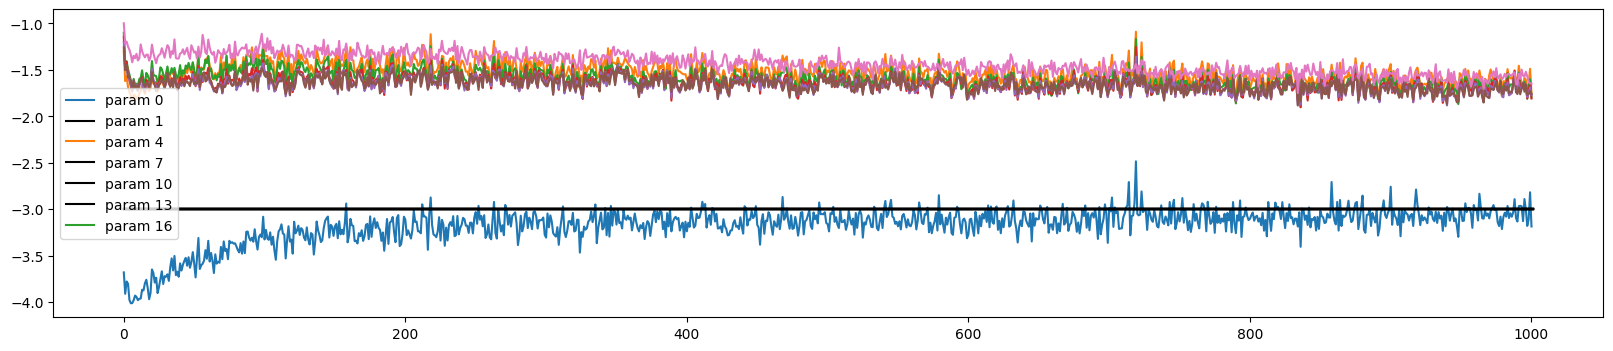

In [32]:
settings_dict = dict(
    is_batch_norm_enable=True,
    is_there_activation=True,
    is_bias_zero=False,
    lr=0.1,
    gain=0.2
)
g = torch.Generator().manual_seed(214748433) 
settings = Settings(**settings_dict)
layers, parameters, C = generate_parameter(vocab_size,settings,g)
ud = generate_data(Xtr,Ytr,layers,C,parameters,settings,g)
plot_graphs(layers,parameters,ud,settings)